# **Tarea 4 - Sequence to Sequence 📚**

**Procesamiento de Lenguaje Natural (CC6205-1 - Otoño 2024)**

## Tarjeta de identificación

**Nombres:** Matías Rivera, Vicente Thiele, Patricio Espinoza

**Fecha límite de entrega 📆:** 10/07.

**Tiempo estimado de dedicación:** 4 horas


## Instrucciones

Bienvenid@s a la tercera tarea en el curso de Natural Language Processing (NLP). Esta tarea tiene como objetivo evaluar los contenidos teóricos de las últimas semanas de clases posteriores a la Tarea 3, enfocado en **Sequence-to-Sequence + Attention**. Si aún no has visto las clases, se recomienda visitar los links de las referencias.

* La tarea es en **grupo** (maximo hasta 3 personas).
* La entrega es a través de u-cursos a más tardar el día estipulado arriba.
* El formato de entrega es este mismo Jupyter Notebook.
* Al momento de la revisión su código será ejecutado. Por favor verifiquen que su entrega no tenga errores de compilación.
* Completar la tarjeta de identificación. Sin ella no podrá tener nota.
* Recomendamos mirar el enunciado completo con atención (*ba dum tss*) antes de empezar la tarea, para tener una idea más completa de lo que se pide.

## Material de referencia

Diapositivas del curso 📄
    
- [Sequence-to-Sequence + Attention](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-seq2seq.pdf)
- [Transformer](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-transformer.pdf)

Videos del curso 📺

- [Sequence-to-Sequence + Attention](https://www.youtube.com/watch?v=OpKxRjISqmM&list=PLppKo85eGXiXIh54H_qz48yHPHeNVJqBi&index=35)
- [Transformer](https://www.youtube.com/watch?v=8RE23Uq8rU0)

## Parte 1: Traducción automática con arquitectura Encoder-Decoder con RNNs
En esta sección crearemos nuestro propio traductor de español a inglés con la arquitecura Encoder-Decoder con RNNs + Attention vista en clases.

In [245]:
## Importamos librerías

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

### P0. Preparación del dataset y tokenización

Utilizaremos un dataset de pares de oraciones en inglés y castellano.

In [246]:
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2024-07-10 01:33:59--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip.4’

spa-eng.zip.4       100%[===================>]   5.17M  2.81MB/s    in 1.8s    

2024-07-10 01:34:02 (2.81 MB/s) - ‘spa-eng.zip.4’ saved [5420295/5420295]

Archive:  spa-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Vamos a crear una clase que nos permita procesar mejor cada idioma del corpus. Esto nos será útil para manejar dos vocabularios distintos.

In [247]:
# Código base

SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "*", 1: "STOP"}
    self.n_tokens = 2  # * y STOP

  def add_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_tokens
      self.word2count[word] = 1
      self.index2word[self.n_tokens] = word
      self.n_tokens += 1
    else:
      self.word2count[word] += 1

Implemente acá funciones para leer, procesar y filtar el dataset según estime.

In [248]:
# Minúsculas, puntuación y remoción de caracteres que no son letras
# Puede añadir cualquier otro preprocesamiento que estime conveniente
def normalize_string(s):
  s = unicodedata.normalize('NFC', s) # Normalización de caracteres unicode
  s = s.lower().strip()
  s = re.sub(r"([.!?])", r" \1", s) # Regex para separar puntuación de las palabras
  s = re.sub(r"[^a-zA-Z!?áéíóúñ´]+", r" ", s) # Regex para excluir otros caracteres
  return s.strip()

# Recomendamos mantener sólo oraciones con ~10 palabras o menos
def filter_pairs(pairs, max_length):
  return [p for p in pairs if len(p[0].split(' ')) < max_length and \
                len(p[1].split(' ')) < max_length]

In [249]:
def read_dataset(path, reverse=False):
  lines = open(path, encoding='utf-8').\
    read().strip().split('\n')

  pairs = [[normalize_string(s) for s in l.split('\t')][:2] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang("spa")
    output_lang = Lang("eng")
  else:
    input_lang = Lang("eng")
    output_lang = Lang("spa")

  return input_lang, output_lang, pairs

def read_langs(lang1, lang2, reverse=False, max_length=10):
  input_lang, output_lang, pairs = read_dataset("spa.txt", reverse)
  print(f"Total de oraciones en dataset: {len(pairs)}")
  pairs = filter_pairs(pairs, max_length)
  print(f"Reducido a: {len(pairs)}")
  for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
  print(f"Tamaño vocab {input_lang.name}: {input_lang.n_tokens}")
  print(f"Tamaño vocab {output_lang.name}: {output_lang.n_tokens}")
  return input_lang, output_lang, pairs

In [250]:
input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=10)
print(random.choice(pairs))

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
['él es tres años mayor que ella', 'he s three years older than her']


### P1. Encoder (1.2 pt.)
Implemente una red Encoder utilizando redes neuronales recurrentes.

In [251]:
# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [252]:
# Código base, puede cambiar los parámetros acorde a su implementación

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### P2. Attention Decoder (1.8 pt.)

Ahora diseñe un mecanismo de atención según estime conveniente y otra red que servirá de decoder con el modelo de attention. Utilice la predicción objetivo (en caso de existir) como siguiente input de cada oración para la etapa de entrenamiento (teacher forcing).

In [253]:
# Código base, puede cambiar los parámetros acorde a su implementación
MAX_LENGTH = 10

class MyAttention(nn.Module):
  def __init__(self, hidden_size):
    super(MyAttention, self).__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)

    return context, weights

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    super(DecoderRNN, self).__init__()
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.attention = MyAttention(hidden_size)
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    for i in range(MAX_LENGTH):
      decoder_output, decoder_hidden, attn_weights = self.forward_step(
          decoder_input, decoder_hidden, encoder_outputs
      )
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target as the next input
        decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
      else:
         # Without teacher forcing: use its own predictions as the next input
         _, topi = decoder_output.topk(1)
         decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    attentions = torch.cat(attentions, dim=1)

    return decoder_outputs, decoder_hidden, attentions

  def forward_step(self, input, hidden, encoder_outputs):
    embedded =  self.dropout(self.embedding(input))

    query = hidden.permute(1, 0, 2)
    context, attn_weights = self.attention(query, encoder_outputs)
    input_gru = torch.cat((embedded, context), dim=2)

    output, hidden = self.gru(input_gru, hidden)
    output = self.out(output)

    return output, hidden, attn_weights

### P3. Entrenamiento y evaluación (1 pt.)
Entrene su modelo Sequence-to-Sequence. Para esto entrene el encoder, decoder y attention en conjunto, es decir utilizando la misma función de loss para los parámetros de cada componente. Recuerde entregar las predicciones objetivo al decoder en cada iteración.

In [254]:
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [255]:
# Funciones auxiliares para cargar datos de entrenamiento

def sentence2indexes(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def sentence2tensor(lang, sentence):
  indexes = sentence2indexes(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def pair2tensors(pair):
  input_tensor = sentence2tensor(input_lang, pair[0])
  target_tensor = sentence2tensor(output_lang, pair[1])
  return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = read_langs('eng', 'spa', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = sentence2indexes(input_lang, inp)
        tgt_ids = sentence2indexes(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [256]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [257]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

In [258]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_tokens).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=1)

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
1m 25s (- 27m 7s) (1 5%) 2.4367
2m 49s (- 25m 22s) (2 10%) 1.5278
4m 11s (- 23m 47s) (3 15%) 1.2051
5m 34s (- 22m 19s) (4 20%) 1.0225
6m 56s (- 20m 50s) (5 25%) 0.9012
8m 19s (- 19m 26s) (6 30%) 0.8112
9m 42s (- 18m 2s) (7 35%) 0.7413
11m 5s (- 16m 38s) (8 40%) 0.6864
12m 28s (- 15m 14s) (9 45%) 0.6402
13m 50s (- 13m 50s) (10 50%) 0.6015
15m 13s (- 12m 27s) (11 55%) 0.5698
16m 35s (- 11m 3s) (12 60%) 0.5413
17m 58s (- 9m 40s) (13 65%) 0.5156
19m 20s (- 8m 17s) (14 70%) 0.4955
20m 43s (- 6m 54s) (15 75%) 0.4755
22m 6s (- 5m 31s) (16 80%) 0.4586
23m 28s (- 4m 8s) (17 85%) 0.4433
24m 51s (- 2m 45s) (18 90%) 0.4296
26m 13s (- 1m 22s) (19 95%) 0.4160
27m 36s (- 0m 0s) (20 100%) 0.4042


Comente sus resultados. ¿Cómo evoluciona la loss a medida que aumenta el número de epochs?

```
Se obtuvieron los siguientes resultados:
Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
6m 48s (- 102m 11s) (5 6%) 1.4186
13m 30s (- 94m 31s) (10 12%) 0.6961
20m 17s (- 87m 56s) (15 18%) 0.5195
26m 55s (- 80m 47s) (20 25%) 0.4304
33m 32s (- 73m 47s) (25 31%) 0.3746
40m 6s (- 66m 51s) (30 37%) 0.3361
46m 41s (- 60m 1s) (35 43%) 0.3074
53m 15s (- 53m 15s) (40 50%) 0.2850
59m 49s (- 46m 31s) (45 56%) 0.2675
66m 20s (- 39m 48s) (50 62%) 0.2527
72m 52s (- 33m 7s) (55 68%) 0.2410
79m 22s (- 26m 27s) (60 75%) 0.2309
85m 51s (- 19m 48s) (65 81%) 0.2219

La loss conforme pasan las epocas va disminuyendo, en las primeras disminuye rápidamente y a partir de la 7ma epoca se nota que el descenso es
considerablemente menor. Esto al observar que desde las épocas siguientes (7 -> 14) disminuye un total de 0.2458, mientras que de la primera a
la 7ma disminuye un total de 1.6954, lo cual es considerablemente más.

Se probó con 80 épocas llegando hasta la 65, la entrega esta realizada hasta 20 épocas en intervalos de 1 para un mejor ánalisis.
```

Adapte las siguientes funciones para traducir oraciones con su modelo. Pruebe su traductor con algunas oraciones aleatorias del corpus.

In [259]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
  with torch.no_grad():
    input_tensor = sentence2tensor(input_lang, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
      if idx.item() == EOS_token:
        decoded_words.append('STOP')
        break
      decoded_words.append(output_lang.index2word[idx.item()])
  return decoded_words, decoder_attn

def evaluate_randomly(encoder, decoder, dataset, n=10):
  for i in range(n):
    pair = random.choice(dataset)
    print('Input:', pair[0])
    print('Traducción:', pair[1])
    output_words, _ = translate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print('Predicción:', output_sentence)
    print('')

In [268]:
encoder.eval()
decoder.eval()
dataset = pairs
evaluate_randomly(encoder, decoder, dataset, 10)

Input: no estás escuchando
Traducción: you re not listening
Predicción: you re not listening to me to scare me STOP

Input: están perfectamente
Traducción: they re fine
Predicción: they re perfectly fine STOP

Input: el tratamiento está siendo exitoso
Traducción: the treatment is going successfully
Predicción: the treatment is as successful successful STOP

Input: qué formas necesitamos nosotros guardar ?
Traducción: what forms do we need to file ?
Predicción: what forms do we need to file ? STOP

Input: según la policía nadie murió
Traducción: according to police no one died
Predicción: according to police no one died STOP

Input: cómo le llamas a esto ?
Traducción: what do you call this ?
Predicción: what s your name to ? STOP

Input: yo no fui una buena madre
Traducción: i was not a good mother
Predicción: i didn t go mother a good mother STOP

Input: sabía que lo encontrarías
Traducción: i knew you d find it
Predicción: i knew you d find it STOP

Input: tom no se podía concentrar e

Comente sus resultados. ¿Qué ocurre con las cuando la traducción predicha es válida pero no igual al ground truth? ¿Qué haría para abordar este problema?

```
Esto se puede deber al parafraseo, es decir que la frase predicha es similar semanticamente a la groudn thuth pero mediante palabras distintas
con significados parecidos, i.e. sinonimos. Asimismo, en un mismo contexto dos palabras pueden ser validas y equivalentes a la misma traducción
de una frase, lo que explicaría la diferencia de resultados.

También se debe a falta de entrenamiento, por ejemplo en "el tratamiento está siendo exitoso" ground truth es "the treatment is
going successfully" y la predicción es "the treatment is as successful successful STOP", que aunque esta muy similar y 'valida' comete
errores gramaticales.

Para abordar este problema una solución es implementar feeedback/evaluaciones hechas por personas además del entrenamiento mismo del modelo,
permitiendo aprender estas variaciones más alla de solo el analisis basado en el algoritmo y en semejanzas en base a contexto estadistico.
Además de permitir aprender estas variaciones, también se espera que el modelo será capaz de corregir aquellas fallas gramaticales.
```

### P4. Visualizando Attention (0.5 pt.)

Ahora visualizaremos los pesos de atención asignados entre las palabras traducidas. Para esto, les entregamos funciones para visualizar los pesos de atención entregados por su decoder a partir de una oración. Adapte el código al output de su modelo de ser necesario.

In [291]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [292]:
%matplotlib inline

In [293]:
def plot_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def show_attention(input_sentence):
    output_words, attentions = translate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    plot_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

Grafique la atención de las siguientes oraciones de ejemplo. Haga lo mismo con al menos tres oraciones más que puedan ser interesantes.

input = tom necesita un poco de ayuda
output = tom needs a little help help STOP


<ipython-input-293-c262c8c7ec7a>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
<ipython-input-293-c262c8c7ec7a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


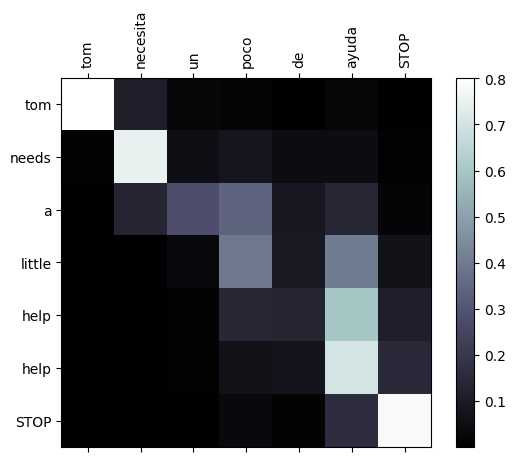

input = el perro corre rápidamente
output = the dog runs quickly quickly STOP


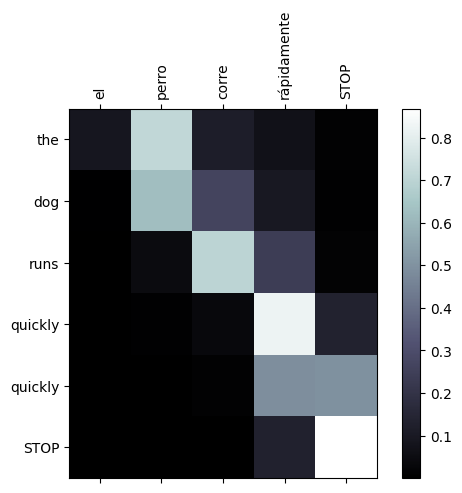

input = el banco le ofreció un alto interés
output = the bank looks kind of a high gift STOP


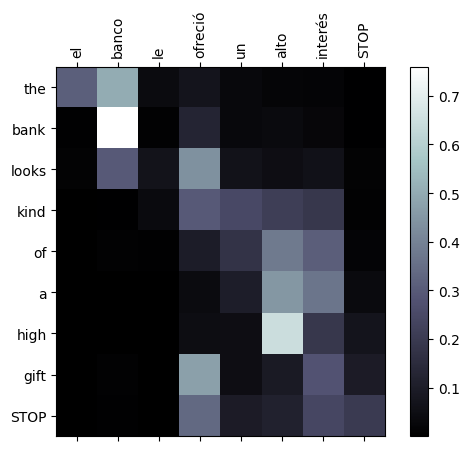

input = él toca la flauta el clarinete y el saxofón
output = he plays the flute the clarinet and the saxophone STOP


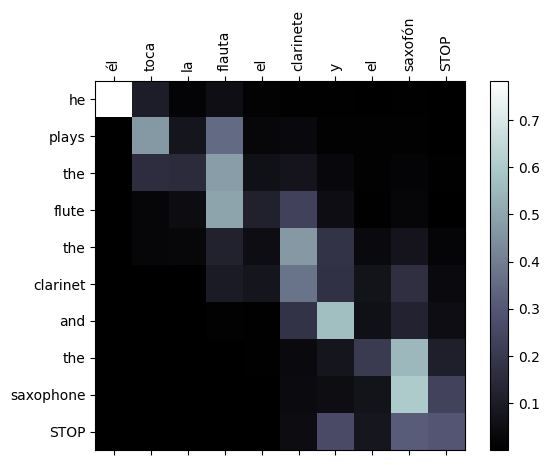

In [294]:
## Oraciones de ejemplo

show_attention('tom necesita un poco de ayuda')

show_attention('el perro corre rápidamente')

show_attention('el banco le ofreció un alto interés')

show_attention('él toca la flauta el clarinete y el saxofón')

input = mi gatito es el mejor del mundo
output = my kitten is the best of the world s STOP


<ipython-input-293-c262c8c7ec7a>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
<ipython-input-293-c262c8c7ec7a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


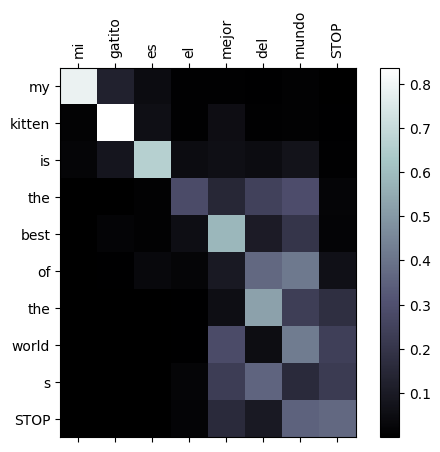

input = hicimos un descanso para tomar café
output = we made a coffee to drink coffee STOP


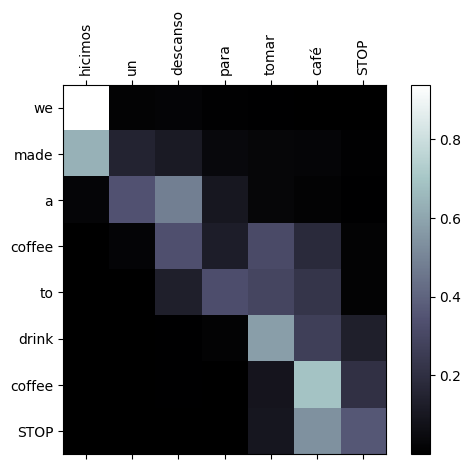

input = se le cayó la guagua de los brazos
output = the report was given a short of his arms STOP


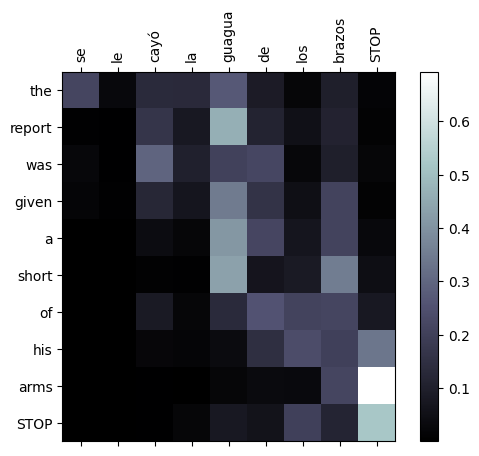

In [295]:
## Oraciones de ejemplo
# Ver si realiza bien una traduccion con diminutivos
show_attention('mi gatito es el mejor del mundo')
# Ver si utiliza el concepto coffee break
show_attention('hicimos un descanso para tomar café')
# Ver como trabaja con palabras usadas en chile como guagua
show_attention('se le cayó la guagua de los brazos')

Comente sus resultados. ¿Eran lo que esperaba?
```
Al utilizar diminutivos esperabamos que hubiera un fallo al predecir dicha palabra, lo mismo con guagua, pues es
mayormente utilizada en países latinoamericanos y su significado varía mucho dependiendo del contexto (en Chile
hace referencia a bebé mientras que en otros países a las micros). Obtuvimos que el diminutivo "gatito" lo pudo
traducir correctamente a kitten, y no a otra palabra o a "cat" que sería válido pero no del todo correcto.
Por otro lado, vemos que para la traducción usando "guagua" el output pierde el significado de la frase original
y la traducción es incorrecta.

Para el segundo ejemplo nos pareció interesante ver si el traductor emplearía el termino coffee break, esperabamos
que no lo utilizará tal y como sucedió. Aún así, su traducción es correcta.
```

## Parte 2: BERT

Lo primero es instalar las librerías necesarias.

In [272]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertForNextSentencePrediction, BertForMaskedLM, BertForQuestionAnswering
import torch

Para las preguntas que siguen, utilizaremos distintas variantes de BERT disponibles en la librería transformers. [Aquí](https://huggingface.co/transformers/model_doc/bert.html) pueden encontrar toda la documentación necesaria. El modelo pre-entrenado a utilizar es "bert-base-uncased" (salvo para question answering).

BERT es un modelo de lenguaje que fue entrenado exhaustivamente sobre dos tareas: 1) Next sentence prediction. 2) Masked language modeling.

### **BertForNextSentencePrediction** (0.5 pt.)

**Pregunta 1:**  Utilizando el modelo BertForNextSentencePrediction de la librería transformers, muestre cual de las 2 oraciones es **más probable** que sea una continuación de la primera. Para esto defina la función $oracion\_mas\_probable$, que recibe el inicio de una frase, las alternativas para continuar esta frase y retorna un string indicando cual de las dos oraciones es más probable.

Por ejemplo:

Initial: "The sky is blue."\
A: "This is due to the shorter wavelength of blue light."\
B: "Chile is one of the world's greatest economies."

Debería retornar "La oración que continúa más probable es A", justificándolo con la evaluación de BERT.



In [273]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

In [274]:
def oracion_mas_probable(first,sentA,sentB):
  #Tu implementacion
  encodingA = tokenizer(first, sentA, return_tensors='pt')
  encodingB = tokenizer(first, sentB, return_tensors='pt')
  outputA = model(**encodingA, labels=torch.LongTensor([1]))
  outputB = model(**encodingB, labels=torch.LongTensor([1]))
  logitsA = outputA.logits
  logitsB = outputB.logits

  # Obtenemos las probs de logits
  probA = torch.softmax(logitsA, dim=1)[0][0].item()
  probB = torch.softmax(logitsB, dim=1)[0][0].item()

  # Comparar probs
  if probA > probB:
    sentence = sentA
  else:
    sentence = sentB
  print(f"La probabilidad de la oración A es: {probA}")
  print(f"La probabilidad de la oración B es: {probB}")
  return f"La oración que continúa más probable es {sentence}"

1.1)
Initial: "My cat is fluffy."\
A: "My dog has a curling tail."\
B: "A song can make or ruin a person’s day if they let it get to them."

In [275]:
oracion_mas_probable("My cat is fluffy.", "My dog has a curling tail.",  "A song can make or ruin a person’s day if they let it get to them.")

La probabilidad de la oración A es: 0.9999964237213135
La probabilidad de la oración B es: 0.0025219772942364216


'La oración que continúa más probable es My dog has a curling tail.'

1.2)
Initial: "The Big Apple is famous worldwide."\
A: "You can add cinnamon for the perfect combination."\
B: "It is America's largest city."

In [276]:
oracion_mas_probable("The Big Apple is famous worldwide.", "You can add cinnamon for the perfect combination.", "It is America's largest city.")

La probabilidad de la oración A es: 0.9999865293502808
La probabilidad de la oración B es: 0.9999897480010986


"La oración que continúa más probable es It is America's largest city."

1.3)
Initial: "Roses are red."\
A: "Violets are blue."\
B: "Fertilize them regularly for impressive flowers."

In [277]:
oracion_mas_probable( "Roses are red.", "Violets are blue.", "Fertilize them regularly for impressive flowers.")

La probabilidad de la oración A es: 0.9999957084655762
La probabilidad de la oración B es: 0.9999926090240479


'La oración que continúa más probable es Violets are blue.'

1.4)
Initial: "I play videogames the whole day."\
A: "They make me happy."\
B: "They make me rage."\

In [278]:
oracion_mas_probable( "I play videogames the whole day.",  "They make me happy.", "They make me rage.")

La probabilidad de la oración A es: 0.9999908208847046
La probabilidad de la oración B es: 0.9999867677688599


'La oración que continúa más probable es They make me happy.'

### **BertForMaskedLM** (0.5 pt.)

**Pregunta 2:**  Ahora utilizaremos BertForMaskedLM para **predecir una palabra oculta** en una oración.\
Por ejemplo:\
BERT input: "I want to _ a new car."\
BERT prediction: "buy"

In [279]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [280]:
def palabra_mas_probable(sentence):
    # Tu implementacion
    tokenized_text = tokenizer.tokenize(sentence)
    masked_index = tokenized_text.index('[MASK]')
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])

    # predicciones del modelo
    with torch.no_grad():
        predictions = model(tokens_tensor)

    # índice del token más probable en la posición del [MASK]
    predicted_index = torch.argmax(predictions.logits[0, masked_index]).item()

    # índice en el token correspondiente
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

    return predicted_token

2.1)
BERT input: "[CLS] I love [MASK] . [SEP]"

In [281]:
sent = "[CLS] I love [MASK] . [SEP]"
palabra_mas_probable(sent)

'you'

2.2)
BERT input: "[CLS] I hear that Karen is very [MASK] . [SEP]"

In [282]:
sent = "[CLS] I heard that Karen is very [MASK] . [SEP]"
palabra_mas_probable(sent)

'upset'

2.3)
BERT input: "[CLS] She had the gift of being able to [MASK] . [SEP]"

In [283]:
sent = "[CLS] She had the gift of being able to [MASK] . [SEP]"
palabra_mas_probable(sent)

'fly'

2.4)
BERT input: "[CLS] It's not often you find a [MASK] on the street. [SEP]"

In [284]:
sent = "[CLS] It's not often you find an [MASK] on the circus . [SEP]"
palabra_mas_probable(sent)

'expert'

### **BertForQuestionAnswering** (0.5 pt.)

**Pregunta 3**  Utilizando el modelo BertForQuestionAnswering pre-entrenado con 'bert-large-uncased-whole-word-masking-finetuned-squad', **extraiga la respuesta** a cada una de las siguientes 4 preguntas y su contexto. Recuerde cambiar el tokenizer para que coincida con el modelo.

In [285]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [286]:
def entregar_respuesta(qst, cntxt):
    # Tokenizamos la pregunta y el contexto
    inputs = tokenizer(qst, cntxt, return_tensors='pt', truncation=True, padding=True)

    # Obtenemos las puntuaciones de inicio y fin de la respuesta
    with torch.no_grad():
        outputs = model(**inputs)
        start_scores = outputs['start_logits']
        end_scores = outputs['end_logits']

    # Obtenemos las posiciones con las puntuaciones más altas
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores) + 1

    # Convertimos los IDs de tokens a palabras
    all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    answer = tokenizer.convert_tokens_to_string(all_tokens[start_idx:end_idx])

    return answer

3.1)

Pregunta: "When was the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [287]:
q = "When was the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'21 may 1879'

3.2)

Pregunta: "Who won the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [288]:
q = "Who won the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'peruvian'

3.3)

Pregunta: "Who introduced peephole connections to LSTM networks?"
Contexto: "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."

In [289]:
q = "Who introduced peephole connections to LSTM networks?"
c = "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."
entregar_respuesta(q, c)

'gers & schmidhuber'

3.4)

Pregunta: "When is the cat most active?"

Contexto: "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."

In [290]:
q = "When is the cat most active?"
c = "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."
entregar_respuesta(q, c)

'dawn and dusk'